In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import MultiPolygon, Polygon
import seaborn as sns
sns.set()

### Data Cleaning

#### Lok Sabha Candidates Data

In [2]:
df = pd.read_csv("lok_sabha_candidates_data.csv")
df.head()

,State,Constituency,Name,Winner,Party,Symbol,Gender,Criminal Cases,Age,Category,Education,Assets,Liabilities,General Votes,Postal Votes,Total Votes,Over Total Electors In Constituency,Over Total Votes Polled In Constituency,Total Electors
0,Telangana,ADILABAD,SOYAM BAPU RAO,1,BJP,Lotus,MALE,52,52.0,ST,12th Pass,"Rs 30,99,414 ~ 30 Lacs+","Rs 2,31,450 ~ 2 Lacs+",376892,482,377374,25.330684,35.468248,1489790
1,Telangana,ADILABAD,Godam Nagesh,0,TRS,Car,MALE,0,54.0,ST,Post Graduate,"Rs 1,84,77,888 ~ 1 Crore+","Rs 8,47,000 ~ 8 Lacs+",318665,149,318814,21.399929,29.964370,1489790
2,Telangana,ADILABAD,RATHOD RAMESH,0,INC,Hand,MALE,3,52.0,ST,12th Pass,"Rs 3,64,91,000 ~ 3 Crore+","Rs 1,53,00,000 ~ 1 Crore+",314057,181,314238,21.092771,29.534285,1489790
3,Telangana,ADILABAD,NOTA,0,NOTA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13030,6,13036,0.875023,1.225214,1489790
4,Uttar Pradesh,AGRA,Satyapal Singh Baghel,1,BJP,Lotus,MALE,5,58.0,SC,Doctorate,"Rs 7,42,74,036 ~ 7 Crore+","Rs 86,06,522 ~ 86 Lacs+",644459,2416,646875,33.383823,56.464615,1937690


In [3]:
df = df[df["Name"]!="NOTA"]
df["Name"] = [x.title() for x in df["Name"]]

# remove category annotation with Constituency name
df["Constituency"] = [x[0].strip() for x in df["Constituency"].str.split('(')]

In [4]:
# Cleanup Assets and Liabiities columns
df["Assets"].fillna("0",inplace=True)
df["Assets"].replace(["Nil","NIL","Not Available","`"],"0",inplace=True)
df["Assets"] = [float(x.split("~")[0].split("Rs")[-1].replace(",","")) for x in df["Assets"]]

df["Liabilities"].fillna("0",inplace=True)
df["Liabilities"].replace(["Nil","NIL","Not Available","`"],"0",inplace=True)
df["Liabilities"] = [float(x.split("~")[0].split("Rs")[-1].replace(",","")) for x in df["Liabilities"]]

#### States map data

In [5]:
state_map = gpd.read_file("state_map/state_map.shp")
state_map.head()

,ST_NM,geometry
0,Arunachal Pradesh,"POLYGON ((96.08866 29.45997, 96.09428 29.45477..."
1,Assam,"POLYGON ((95.97166 27.96254, 95.97174 27.96227..."
2,Chandigarh,"POLYGON ((76.77175 30.79498, 76.77231 30.79420..."
3,Karnataka,"POLYGON ((77.32647 18.45884, 77.32648 18.45803..."
4,Manipur,"POLYGON ((94.57315 25.69156, 94.57522 25.69094..."


In [6]:
# There are some naming and geographical issues that need 
# to be addressed to align state names in map data to Lok Sabha candidates data
set(df.groupby("State").groups.keys()).symmetric_difference(set(state_map.groupby("ST_NM").groups.keys()))

{'Andaman & Nicobar',
 'Andaman & Nicobar Islands',
 'Dadra & Nagar Haveli',
 'Dadra and Nagar Haveli and Daman and Diu',
 'Daman & Diu',
 'Delhi',
 'Ladakh',
 'NCT OF Delhi'}

In [7]:
# renaming changes
state_map["ST_NM"][state_map["ST_NM"]=='Andaman & Nicobar'] = 'Andaman & Nicobar Islands'
state_map["ST_NM"][state_map["ST_NM"]=='Delhi'] = 'NCT OF Delhi'

# geographical changes
state_map.loc[len(state_map)] = ["Dadra & Nagar Haveli",MultiPolygon(state_map[state_map["ST_NM"]=="Dadra and Nagar Haveli and Daman and Diu"]["geometry"].values[0][1:])]
state_map.loc[len(state_map)] = ["Daman & Diu",state_map[state_map["ST_NM"]=="Dadra and Nagar Haveli and Daman and Diu"]["geometry"].values[0][0]]
state_map["geometry"][state_map["ST_NM"]=="Jammu & Kashmir"] = MultiPolygon([state_map[state_map["ST_NM"]=="Jammu & Kashmir"]["geometry"].values[0],state_map[state_map["ST_NM"]=="Ladakh"]["geometry"].values[0]])

state_map = state_map[~state_map.ST_NM.isin(["Dadra and Nagar Haveli and Daman and Diu","Ladakh"])]

state_map.set_index("ST_NM",inplace=True)

C:\Users\deepa\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\deepa\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


### Variation in Assets

In [8]:
major_parties = list(df["Party"].value_counts().sort_values().index[-16:])

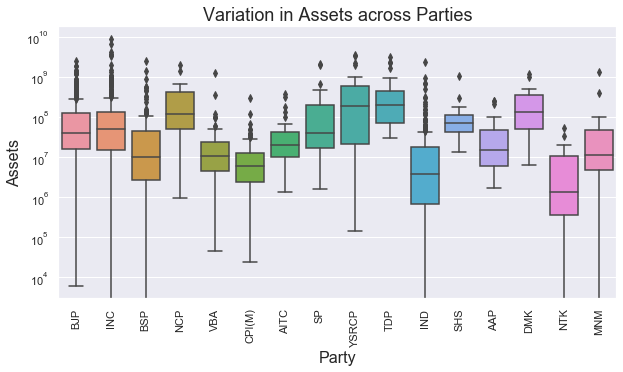

In [9]:
fig,ax = plt.subplots(1,figsize=(10,5))
ax = sns.boxplot(x="Party",y="Assets",data=df[df["Party"].isin(major_parties)],ax=ax)
ax.set_yscale("log")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_xlabel("Party",fontsize=16)
ax.set_ylabel("Assets",fontsize=16)
ax.set_title("Variation in Assets across Parties",fontsize=18)
plt.savefig("assets/party_assets.jpg",bbox_inches = "tight")

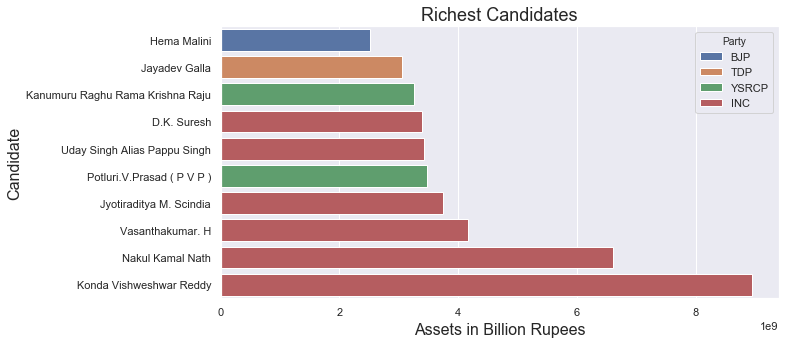

In [10]:
richest_candidates = df.loc[df["Assets"].sort_values().index[-10:]]
fig,ax = plt.subplots(1,figsize=(10,5))
ax = sns.barplot(y="Name",x="Assets", hue="Party", data=richest_candidates, dodge=False)
ax.set_ylabel("Candidate",fontsize=16)
ax.set_xlabel("Assets in Billion Rupees",fontsize=16)
ax.set_title("Richest Candidates",fontsize=18)
plt.savefig("assets/richest.jpg",bbox_inches = "tight")

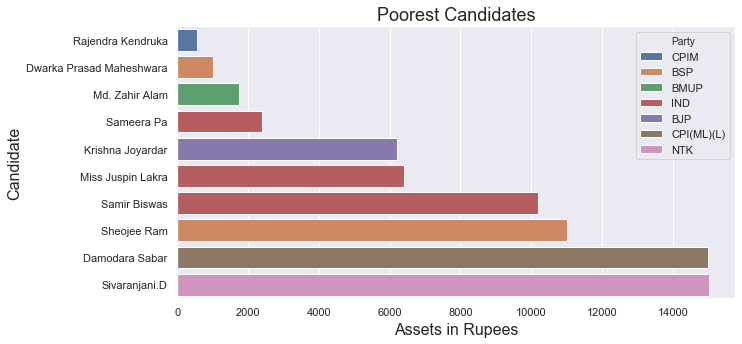

In [11]:
poorest_candidates = df[df["Assets"]>0]
poorest_candidates = poorest_candidates.loc[poorest_candidates["Assets"].sort_values().index[:10]]
fig = plt.figure(figsize=(10,5))
ax = sns.barplot(y="Name",x="Assets",hue="Party", data=poorest_candidates, orient="h", dodge=False)
ax.set_ylabel("Candidate",fontsize=16)
ax.set_xlabel("Assets in Rupees",fontsize=16)
ax.set_title("Poorest Candidates",fontsize=18)
plt.savefig("assets/poorest.jpg",bbox_inches = "tight")

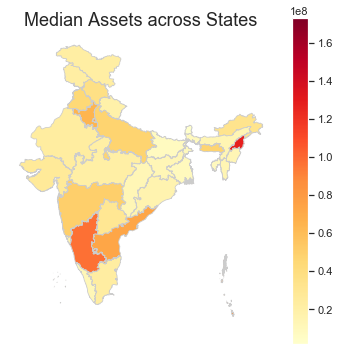

In [12]:
state_wise_assets = pd.merge(state_map, pd.DataFrame(df.groupby("State")["Assets"].median()), left_index=True, right_index=True)

fig, ax = plt.subplots(1, figsize=(6, 6))
ax.axis('off')
ax.set_title('Median Assets across States', fontsize=18)
state_wise_assets.plot(column='Assets', cmap='YlOrRd', linewidth=0.8, edgecolor='0.8', legend=True, ax=ax)
plt.savefig("assets/median_assets_states.jpg",bbox_inches = "tight")

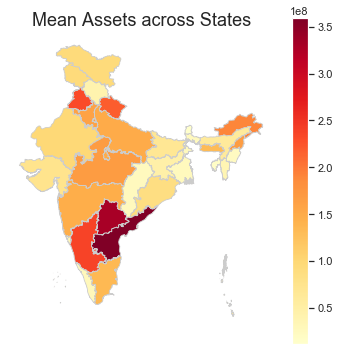

In [13]:
state_wise_assets = pd.merge(state_map, pd.DataFrame(df.groupby("State")["Assets"].mean()), left_index=True, right_index=True)

fig, ax = plt.subplots(1, figsize=(6, 6))
ax.axis('off')
ax.set_title('Mean Assets across States', fontsize=18)
state_wise_assets.plot(column='Assets', cmap='YlOrRd', linewidth=0.8, edgecolor='0.8', legend=True, ax=ax);
plt.savefig("assets/mean_assets_states.jpg")

High numbers for Telangana and Andhra Pradesh in mean plots despite having rather ordinary numbers in median plots indicate wealth concentration with "Super Rich" candidates.

### Variation in Criminal Cases

In [14]:
df["Criminal Cases"].replace("Not Available",0,inplace=True)
df["Criminal Cases"] = df["Criminal Cases"].astype(np.int32)

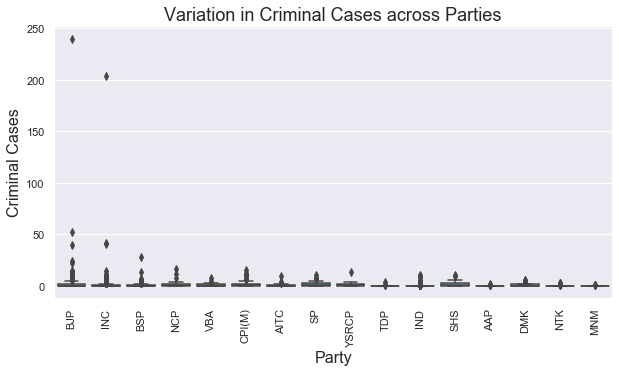

In [15]:
fig = plt.figure(figsize=(10,5))
ax = sns.boxplot(x="Party",y="Criminal Cases",data=df[df["Party"].isin(major_parties)])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_xlabel("Party",fontsize=16)
ax.set_ylabel("Criminal Cases",fontsize=16)
ax.set_title("Variation in Criminal Cases across Parties",fontsize=18);

Interesting that criminal cases have such a large variation that it fails to fit on uniform scale.

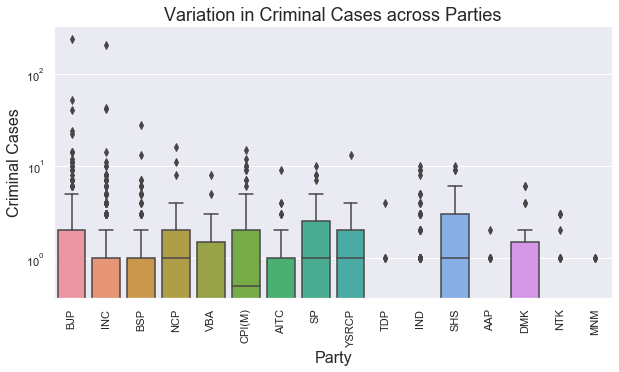

In [16]:
fig = plt.figure(figsize=(10,5))
ax = sns.boxplot(x="Party",y="Criminal Cases",data=df[df["Party"].isin(major_parties)])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_xlabel("Party",fontsize=16)
ax.set_yscale("log")
ax.set_ylabel("Criminal Cases",fontsize=16)
ax.set_title("Variation in Criminal Cases across Parties",fontsize=18)
plt.savefig("assets/party_criminal_cases.jpg",bbox_inches = "tight")

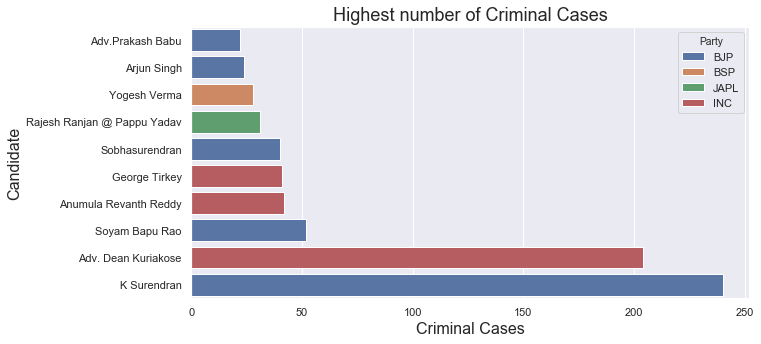

In [17]:
shady_candidates = df.loc[df["Criminal Cases"].sort_values().index[-10:]]
fig = plt.figure(figsize=(10,5))
ax = sns.barplot(y="Name",x="Criminal Cases", hue="Party", data=shady_candidates, dodge=False)
ax.set_ylabel("Candidate",fontsize=16)
ax.set_xlabel("Criminal Cases",fontsize=16)
ax.set_title("Highest number of Criminal Cases",fontsize=18)
plt.savefig("assets/most_criminal_cases.jpg",bbox_inches = "tight")

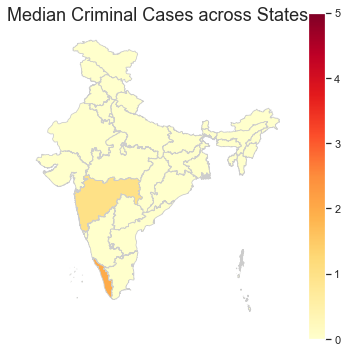

In [18]:
state_wise_assets = pd.merge(state_map, pd.DataFrame(df.groupby("State")["Criminal Cases"].median()), 
                             left_index=True, right_index=True)

fig, ax = plt.subplots(1, figsize=(6, 6))
ax.axis('off')
ax.set_title('Median Criminal Cases across States', fontsize=18)
state_wise_assets.plot(column='Criminal Cases', cmap='YlOrRd', linewidth=0.8, edgecolor='0.8', legend=True, ax=ax)
plt.savefig("assets/median_cases_states.jpg")

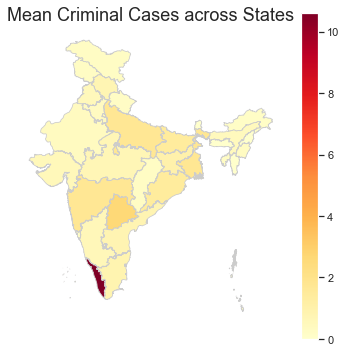

In [19]:
state_wise_assets = pd.merge(state_map, pd.DataFrame(df.groupby("State")["Criminal Cases"].mean()), 
                             left_index=True, right_index=True)

fig, ax = plt.subplots(1, figsize=(6, 6))
ax.axis('off')
ax.set_title('Mean Criminal Cases across States', fontsize=18)
state_wise_assets.plot(column='Criminal Cases', cmap='YlOrRd', linewidth=0.8, edgecolor='0.8', legend=True, ax=ax)
plt.savefig("assets/mean_cases_states.jpg")

Both the candidates with more than 200 criminal cases belong to Kerala. On removing them (assuming outliers!) a more interesting plot emerges when we visualize maximum number of cases against any candidate in the state.

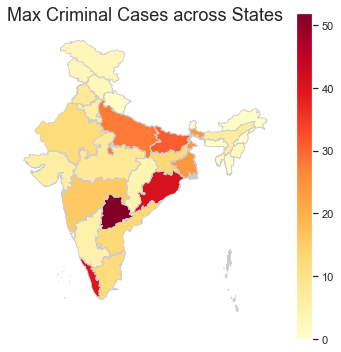

In [20]:
temp_df = df[~df["Name"].isin(["K Surendran", "Adv. Dean Kuriakose"])]
state_wise_assets = pd.merge(state_map, pd.DataFrame(temp_df.groupby("State")["Criminal Cases"].max()), 
                             left_index=True, right_index=True)

fig, ax = plt.subplots(1, figsize=(6, 6))
ax.axis('off')
ax.set_title('Max Criminal Cases across States', fontsize=18)
state_wise_assets.plot(column='Criminal Cases', cmap='YlOrRd', linewidth=0.8, edgecolor='0.8', legend=True, ax=ax)
plt.savefig("assets/max_cases_states.jpg")

### Correlation between winning, assets and criminal cases

In [21]:
df["assets_rank"] = df.groupby(["State","Constituency"])["Assets"].rank("dense",ascending=False)
df["cases_rank"] = df.groupby(["State","Constituency"])["Criminal Cases"].rank("dense",ascending=False)

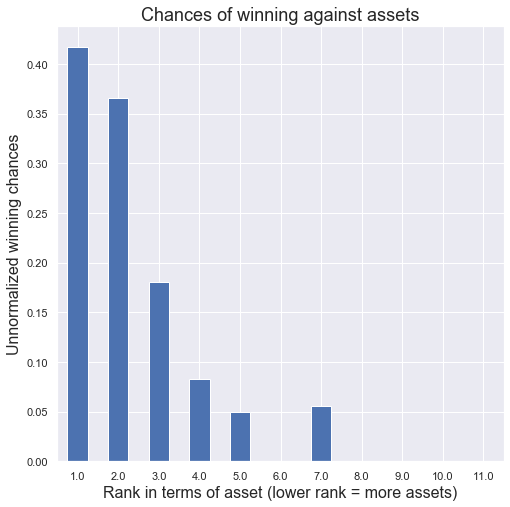

In [22]:
fig = plt.figure(figsize=(8,8))
ax = df.groupby("assets_rank")["Winner"].mean().plot.bar(rot=0)
ax.set_xlabel("Rank in terms of asset (lower rank = more assets)",fontsize=16)
ax.set_ylabel("Unnormalized winning chances",fontsize=16)
ax.set_title("Chances of winning against assets",fontsize=18)
plt.savefig("assets/win_assets.jpg", bbox_inches = "tight")

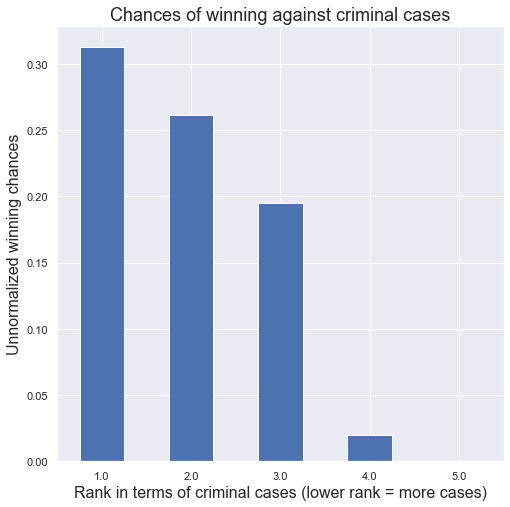

In [23]:
fig = plt.figure(figsize=(8,8))
ax = df.groupby("cases_rank")["Winner"].mean().plot.bar(rot=0)
ax.set_xlabel("Rank in terms of criminal cases (lower rank = more cases)",fontsize=16)
ax.set_ylabel("Unnormalized winning chances",fontsize=16)
ax.set_title("Chances of winning against criminal cases",fontsize=18)
plt.savefig("assets/win_cases.jpg",bbox_inches = "tight")

Correlation $\neq$ Causation but still such correlations are troubling to say the least.

P.S. No constituency has less than 2 candidates.